In [54]:
import numpy as np
import mjp_estimation as mjp
from mjp_estimation.base_functionality import Simulator, DiscreteSample, JointKolmogorovSolver
from mjp_estimation.estimators import MLEDiscreteODE, MLESGD, CLSDiscreteODE, CLSSGD
from mjp_estimation.plots import plot_jackson_paths
from mjp_estimation import jackson_model
from mjp_estimation.optimizers import PolyakRuppertSGD, AdamW
from mjp_estimation.objectives import DiscreteLikelihoodSimulationMiniBatch, SimulatedConditionalLeastSquaresMiniBatch
from mjp_estimation.plots import plot_parameter_convergence
from mjp_estimation.jackson_model import encode, number_in_system

We instantiate a periodic tandem queue with two stations, with specified capacities and number of servers. The arrival rate is periodic according to $\lambda(t) = \theta_1 + \theta_2 \cos(\frac{2\pi}{10} t)$, while the per-server service rates are parameterized as time-invariant ($\theta_3$ and $\theta_4$, respectively).

In [49]:
model = jackson_model.TandemQueuePeriodicArrivalsConstantService(
    capacities=[25, 35],
    num_servers=[10, 5],
    period=10.,
    arrival_base_rate=1,
    arrival_amplitude=0.5,
    service_base_rates=[0.2, 0.25],
    feedback_p=0.,
)
print(f"Model initialized.")
print(f"True Parameter θ =", model.theta_true)

Model initialized.
True Parameter θ = [1.   0.5  0.2  0.25]


We initialize a simulator object based on the model, and simulate a path of length 100. We plot the path for visualization, and create a DiscreteSample object by sampling the path at unit intervals.

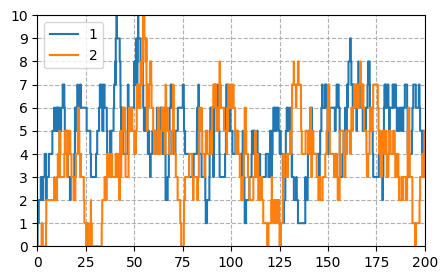

In [105]:
simulator = Simulator(model)
path = simulator.simulate_single_run(200., 0., theta=model.theta_true)
plot_jackson_paths(path, model.d_vec)
delta = 1.
discrete_path = DiscreteSample(path, np.arange(delta, path.final_time+1e-8))

Next, we produce a maximum likelihood estimate $\hat{\theta}_{mle}$ via the BHHH algorithm, using ODE solving to produce transient probabilities. Note that the method used prints diagnostic information such as the efficiency gain obtained by using Hopcroft-Karp internally to allocate between Kolmogorov forward equation (KFE) solves and Kolmogorov backward equation (KBE) solves.

In [106]:
mle_ode_est = MLEDiscreteODE(model)
mle_ode_est.fit(discrete_path, theta_initial=np.array([1., 0., 0.3, 0.2]), xtol=1e-2, gtol=1e-2)

efficiency gain: 9.49%; # Optimal Solves: 143; # KFE-Only Solves: 158, # KBE-Only Solves: 159, # Samples: 200
it=0, theta=array([1. , 0. , 0.3, 0.2]), f=np.float64(617.59017996478)
grad=array([   4.78660716,  -39.08030523,  304.20339068, -251.01182948])
inc=array([ 0.2496302 , -0.56058196,  0.14941132, -0.02263258])
Proposed update: [0.7503698  0.56058196 0.15058868 0.22263258]
it=1, theta=array([0.7503698 , 0.56058196, 0.15058868, 0.22263258]), f=np.float64(586.8773583477497)
grad=array([ -43.39663187,   32.56224767, -124.05146227,  -16.8097474 ])
inc=array([-0.11950427,  0.0150965 , -0.03256159, -0.03406559])
Proposed update: [0.86987407 0.54548546 0.18315027 0.25669816]
it=2, theta=array([0.86987407, 0.54548546, 0.18315027, 0.25669816]), f=np.float64(581.5920394002585)
grad=array([-12.2975886 ,  10.05660525, -13.1346522 ,  20.35075377])
inc=array([-0.02601159,  0.05631335, -0.006003  ,  0.00646587])
Proposed update: [0.89588566 0.48917211 0.18915327 0.25023229]
it=3, theta=array([0.

Once a parameter estimate has been obtained, we call the `evaluate()` method of the `MLEDiscreteODE` object to compute the confidence interval and coverage information. These data are stored in the `results` dictionary, an attribute of the `MLEDiscreteODE` object.

In [107]:
mle_ode_est.evaluate(model.theta_true, alpha=0.05)
print(f"Confidence Region Covers? {mle_ode_est.results['is_good_CI']}")
print(f"Confidence Region Volume: {mle_ode_est.results['CI_volume']:.4f}")
print(f"Euclidean Distance to θ*: {mle_ode_est.results['euclidean_distance']:.4f}")

Confidence Region Covers? True
Confidence Region Volume: 0.0017
Euclidean Distance to θ*: 0.1052


One may alternatively produce a conditional least squares estimate $\hat{\theta}_{cls}$ using ODE solving. To do so we must specify a functional to use in the least squares objective; here we choose the number in system, implemented in `jackson_model`.

In [108]:
h = number_in_system(model)
cls_ode = CLSDiscreteODE(model, h)
cls_ode.fit(discrete_path, theta_initial=np.array([1.2, 0.5, 0.2, 0.2]), tol=1e-3)
cls_ode.evaluate(model.theta_true)
print(f"Confidence Region Covers? {cls_ode.results['is_good_CI']}")
print(f"Confidence Region Volume: {cls_ode.results['CI_volume']:.4f}")
print(f"Euclidean Distance to θ*: {cls_ode.results['euclidean_distance']:.4f}")

it=0, theta=array([1.2, 0.5, 0.2, 0.2]), rss=np.float64(357.74628782913646)
Shrinking step size: eta=0.5, because [ 0.83157165  0.59550834 -0.00494155  0.24602495] violated constraints
it=1, theta=array([1.01578582, 0.54775417, 0.09752923, 0.22301248]), rss=np.float64(324.1503637847719)
it=2, theta=array([0.90992578, 0.59552457, 0.14293912, 0.26063117]), rss=np.float64(312.12535499760963)
it=3, theta=array([0.95877178, 0.59613237, 0.18802315, 0.27059525]), rss=np.float64(312.1062969183357)
it=4, theta=array([0.96087273, 0.59590543, 0.1841963 , 0.27171006]), rss=np.float64(312.1054451216512)
it=5, theta=array([0.96342932, 0.59595223, 0.18730418, 0.27214472]), rss=np.float64(312.10540307505903)
Confidence Region Covers? True
Confidence Region Volume: 0.1842
Euclidean Distance to θ*: 0.1060


As expected, the confidence region for the CLS estimate is significantly larger. Also, note that the estimate itself is further from the true parameter in Euclidean distance.